# Olly-or-not

Identify if a picture of a Springer Spaniel is Olly the dog. Provide your own pictures of Olly the dog.

# Initialisation

In [2]:
from fastai.vision.all import *
from fastai.vision.widgets import *

data_path = "data/ollyornot"

# Get data

In [3]:
from duckduckgo_search import ddg_images
from fastdownload import download_url
from time import sleep


def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot("image")


searches = [
    "springer spaniel photo",
    "springer spaniel sun photo",
    "springer spaniel shade photo",
    "springer spaniel sleep photo",
    "springer spaniel lead photo",
    "springer spaniel forest photo",
    "springer spaniel walk photo",
    "springer spaniel play photo",
    "springer spaniel sleep photo",
]
output_path = f"{data_path}/springer_spaniel"

for search in searches:
    download_images(output_path, urls=search_images(search))
    sleep(10)

Searching for 'springer spaniel photo'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Searching for 'springer spaniel sun photo'
Searching for 'springer spaniel shade photo'
Searching for 'springer spaniel sleep photo'
Searching for 'springer spaniel lead photo'
Searching for 'springer spaniel forest photo'
Searching for 'springer spaniel walk photo'
Searching for 'springer spaniel play photo'
Searching for 'springer spaniel sleep photo'


In [28]:
# resize_images(f"{data_path}/springer_spaniel", max_size=640, dest=f"{data_path}/springer_spaniel")

In [5]:
failed = verify_images(get_image_files(f"{data_path}/springer_spaniel"))
print(failed)
failed.map(Path.unlink)
len(failed)

[]


0

# Create a model

In [49]:
def create_learner(model, item_tfms, batch_tfms):
    # Create the data loaders
    data_block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )
    dls = data_block.dataloaders(data_path, bs=32)

    # Create the learner
    learner = vision_learner(dls, "resnet26d", metrics=error_rate).to_fp16()

    return dls, learner


def train(learner, epochs=5, learn_rate=0.01):
    learner.fine_tune(epochs, learn_rate)


def display_results(learner):
    learner.show_results()

    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()
    interp.plot_top_losses(5, nrows=1)


def go(model, item_tfms, batch_tfms, epochs=5):
    dls, learner = create_learner(model, item_tfms, batch_tfms)
    dls.show_batch()

    # find a good learning rate
    lr = learner.lr_find(suggest_funcs=(valley, slide))
    lr

    train(learner, epochs, learn_rate=lr.slide)

    display_results(learner)

    return dls, learner

## Different item formatting

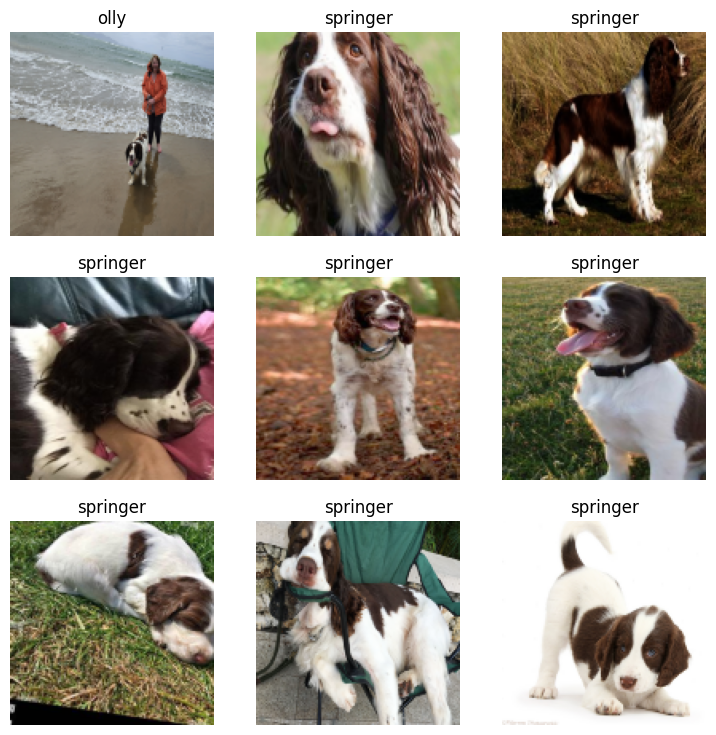

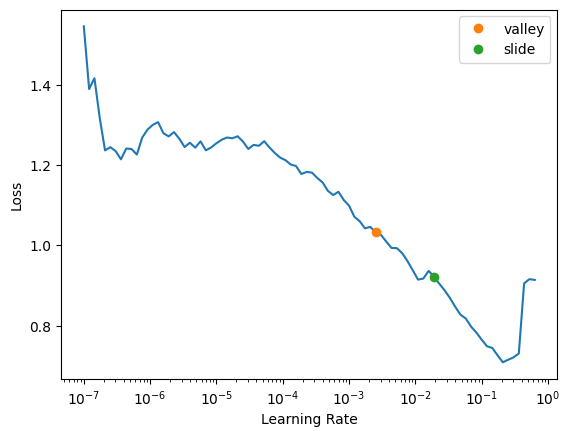

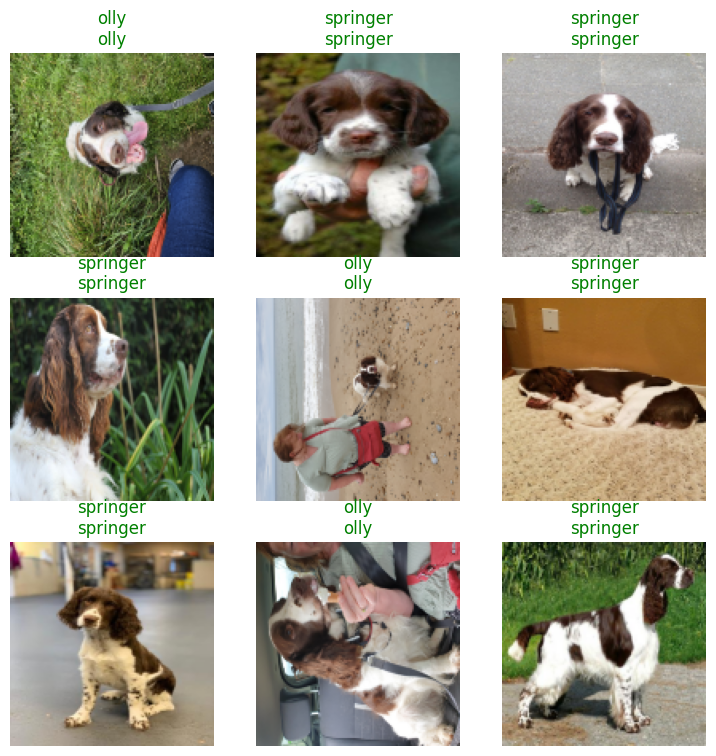

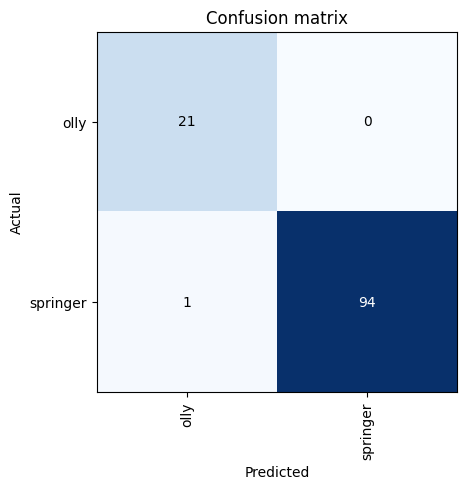

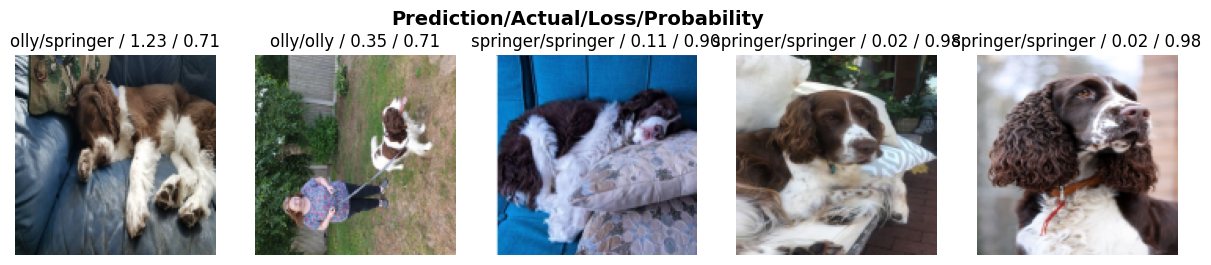

In [50]:
squish = go("convnext_small_in22k", Resize(480, "squish"), aug_transforms(size=128, min_scale=0.75))

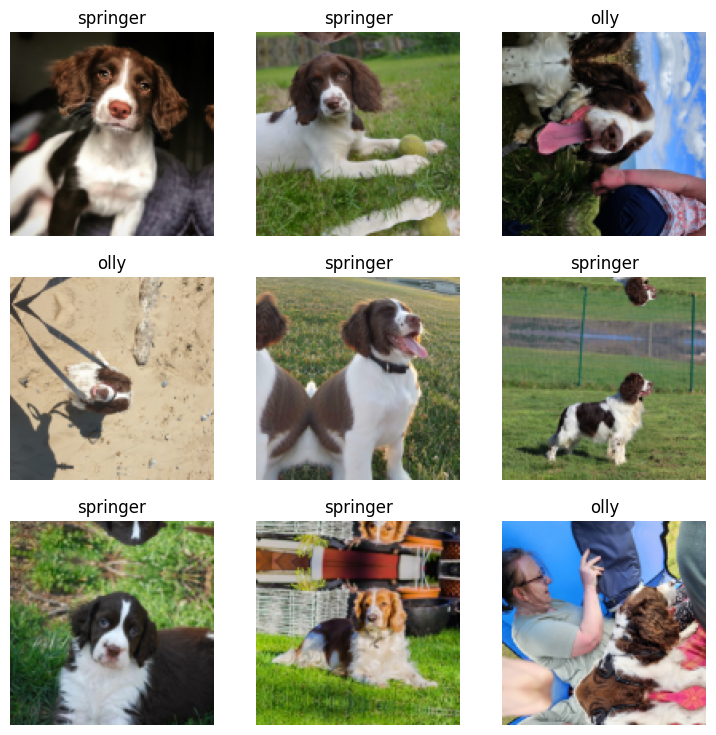

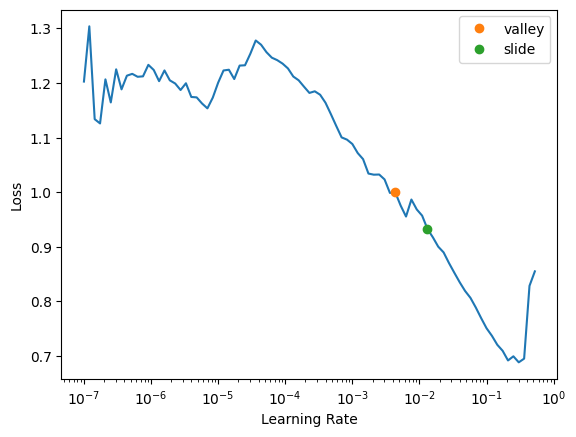

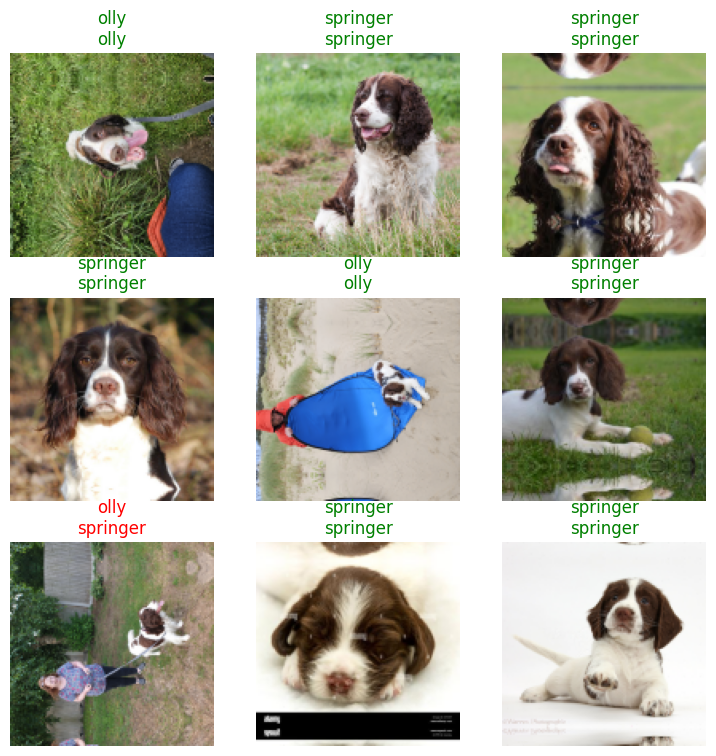

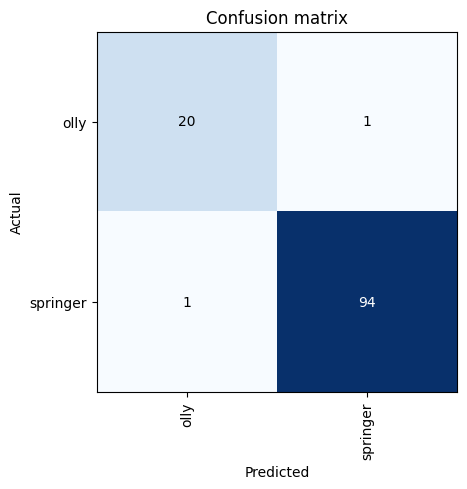

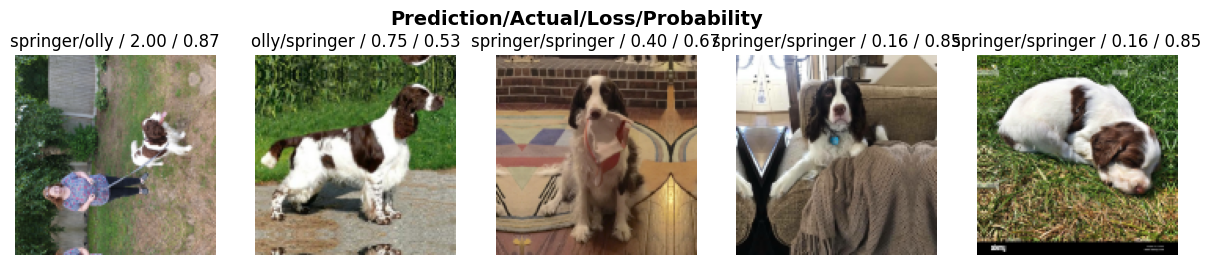

In [51]:
pad = go("convnext_small_in22k", Resize(480, "pad"), aug_transforms(size=128, min_scale=0.75))

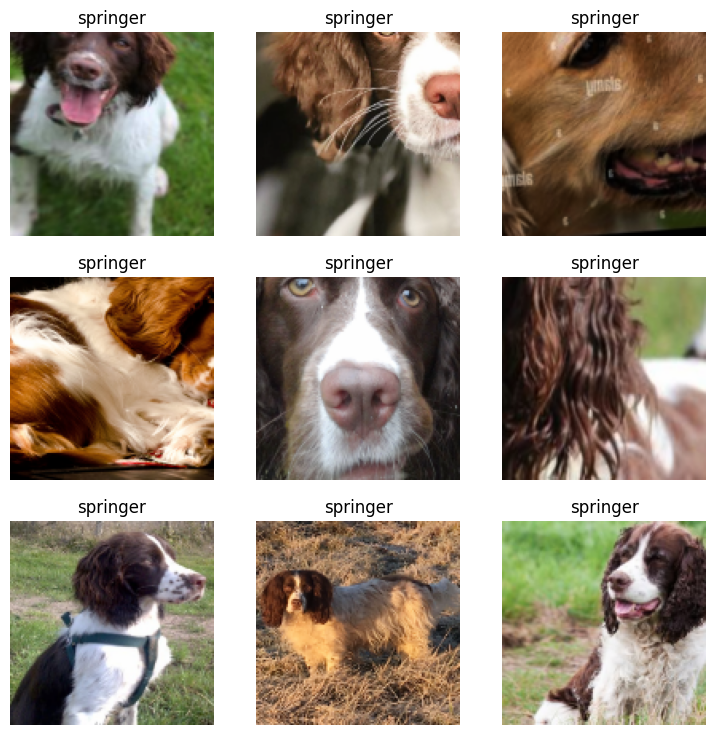

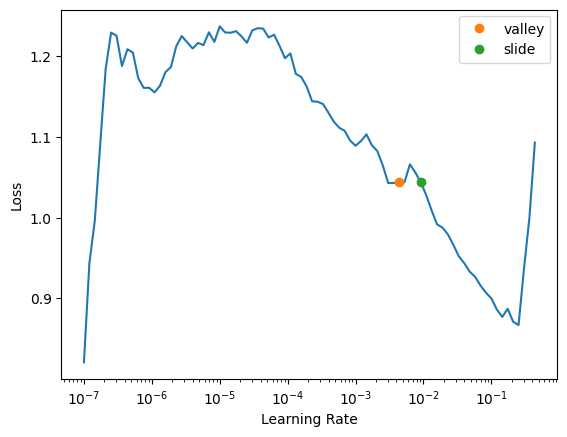

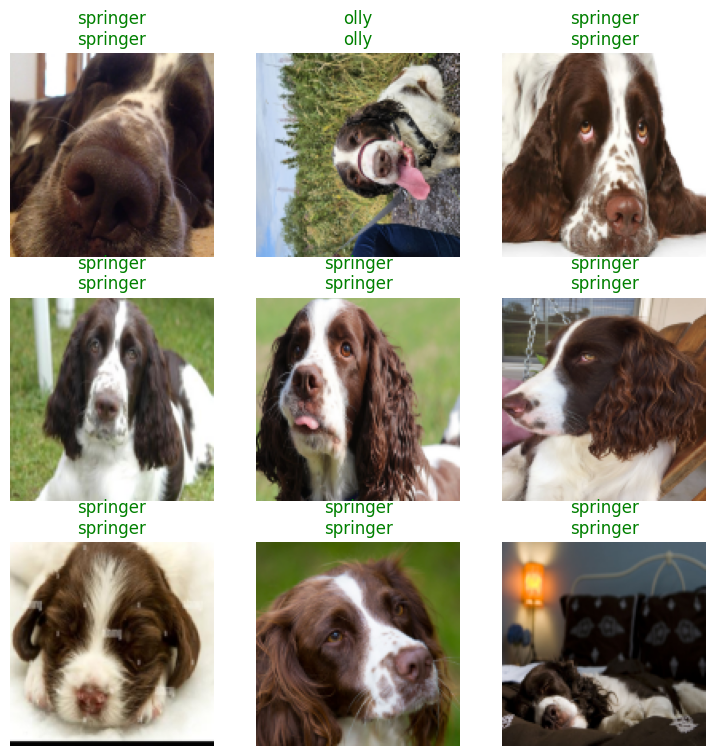

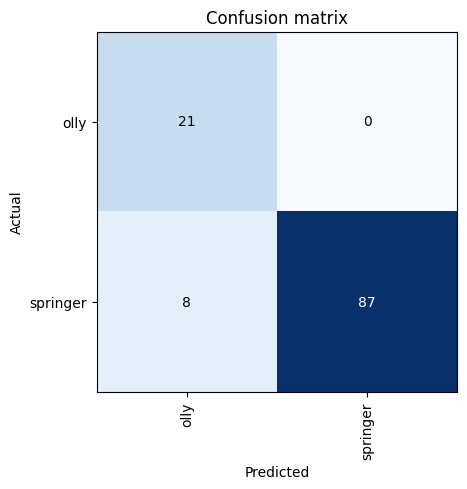

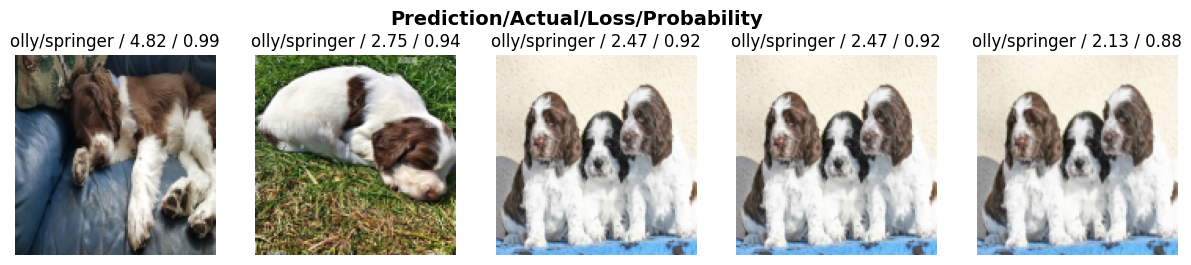

In [52]:
random = go("convnext_small_in22k", RandomResizedCrop(480), aug_transforms(size=128, min_scale=0.75))

In [ ]:
## Bigger

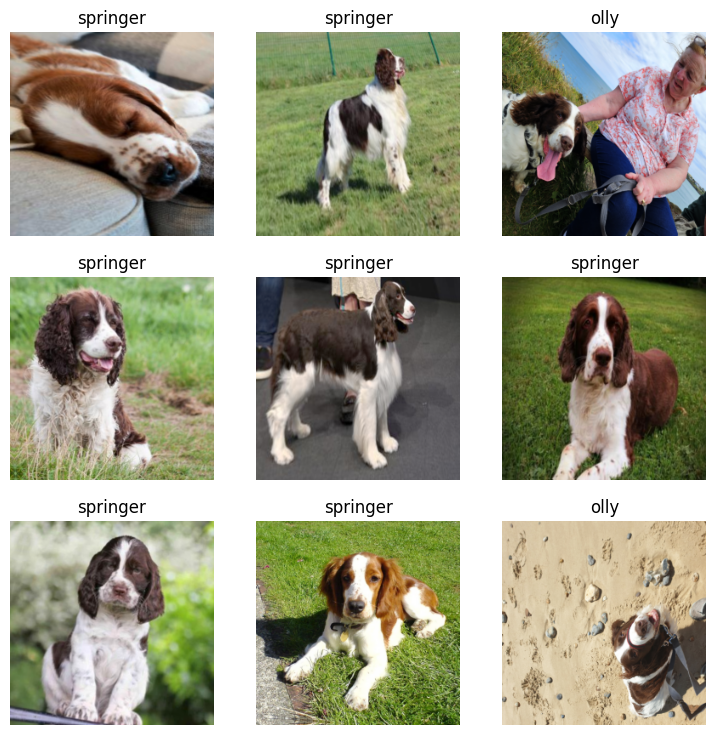

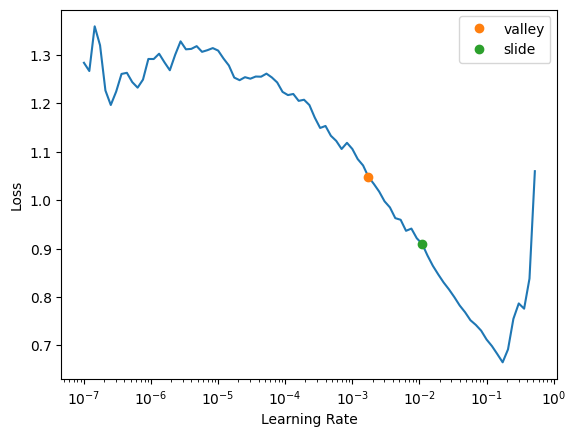

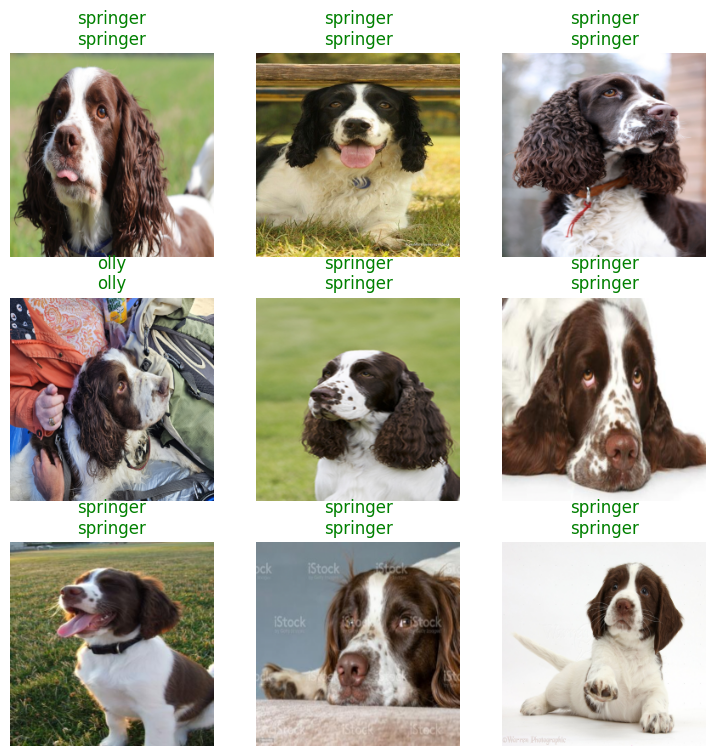

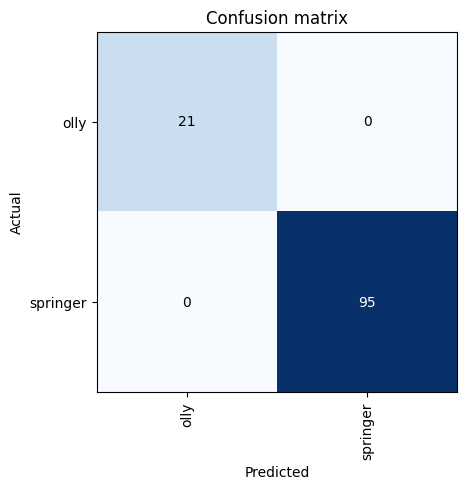

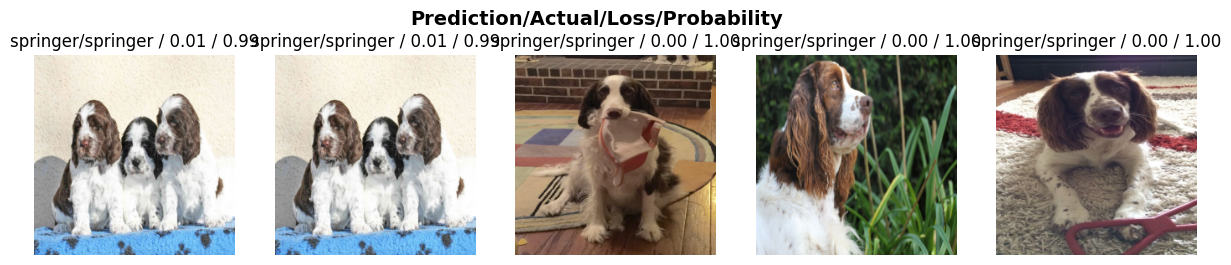

In [54]:
big = go("convnext_large_in22k", Resize(480, "squish"), aug_transforms(size=240, min_scale=0.75), 12)

# Save the model

In [55]:
big[1].export("models/ollyornot.pkl")

# Use in a GUI

In [58]:
import gradio as gr
from fastai.vision.all import *

categories = ("Olly", "Some other Springer")
learner = load_learner("models/ollyornot.pkl")


def classify_img(img):
    try:
        pred, pred_idx, probs = learner.predict(img)
        res = dict(zip(categories, map(float, probs)))
        return res
    except:
        return "Error"


image = gr.components.Image(shape=(400, 400))
label = gr.components.Label()

iface = gr.Interface(
    title="Olly or not",
    description="Tells you if a Springer Spaniel is Olly the Dog.",
    allow_flagging="never",
    theme=gr.themes.Monochrome(),
    fn=classify_img,
    inputs=image,
    outputs=label,
)
iface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
